Dataset shape: (2000, 6)
                                         ProductName  ProductPrice  Rate  \
0  ZEBRONICS Zeb-Vita Plus 16 W Bluetooth Laptop/...        1349.0   5.0   
1  realme Mobile Game Finger Sleeves  Gaming Acce...         199.0   5.0   
2  Shri Vasunandi Traders chandelier_jhoomar_pend...         505.0   1.0   
3  AutoKraftZ Most Popular Sun UV Protection Arm ...         129.0   3.0   
4                      Bajaj GX1 500 W Mixer Grinder        2299.0   4.0   

            Review         Summary Sentiment  
0        Wonderful            nice  positive  
1         Terrific            best  positive  
2  useless product  very bad items  negative  
3        Just okay           Ok ok   Neutral  
4  Worth the money            nice  positive  
Using text column: Review

Daily aggregated sentiment (first 8 rows):
date
2023-01-01    1.0
2023-01-02    1.0
2023-01-03   -1.0
2023-01-04    0.0
2023-01-05    1.0
2023-01-06   -1.0
2023-01-07    1.0
2023-01-08    1.0
Freq: D, Name: sc

/tmp/ipython-input-3034126788.py:62: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  daily = daily.asfreq('D').fillna(method='ffill')   # ensure regular daily index


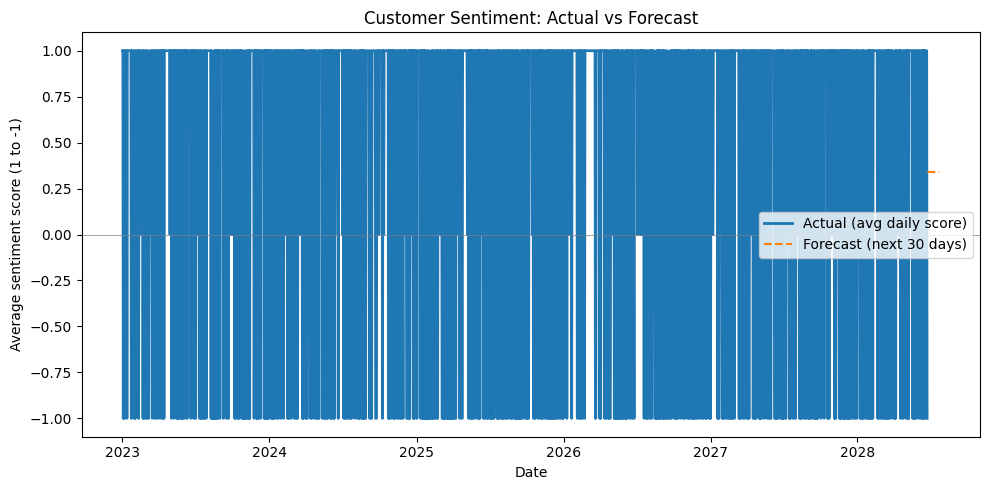


Saved insight report as: AI_insights_report.pdf

--- Quick summary ---
Top unigrams (most frequent): ['nan', 'money', 'purchase', 'awesome', 'wonderful', 'terrific', 'recommended', 'just', 'worth', 'not']
Top bigrams (most frequent): ['highly recommended', 'mind blowing', 'blowing purchase', 'terrific purchase', 'must buy', 'worth every', 'every penny', 'just wow', 'simply awesome', 'absolute rubbish']
Forecast saved for next 30 days. Mean forecasted score: 0.340
Forecast CSV saved as: sentiment_forecast_next30.csv


In [5]:
# ------------------------------
# AI_insights.ipynb — robust forecasting + insights
# (uses Holt exponential smoothing instead of Prophet)
# ------------------------------

# Install required library (run once)
# Uncomment if statsmodels not installed in your environment
# !pip install statsmodels -q

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from collections import Counter
from matplotlib.backends.backend_pdf import PdfPages
import re
import os

# ---- Load dataset ----
data_path = "sentiment_cleaned.csv"   # change if your file is elsewhere
data = pd.read_csv(data_path)
print("Dataset shape:", data.shape)
print(data.head())

# ---- Ensure we have a text column and sentiment column ----
# Common names in your file: 'Review', 'Summary', 'Sentiment'
text_col = None
for col in data.columns:
    if col.lower() in ['review', 'summary', 'clean_text', 'feedback', 'comment']:
        text_col = col
        break
if text_col is None:
    raise ValueError("No text column found. Expected one of: Review, Summary, clean_text, feedback, comment.")

if 'Sentiment' not in data.columns:
    raise ValueError("No 'Sentiment' column found. Please include it (values: positive/negative/neutral).")

print(f"Using text column: {text_col}")

# ---- Create synthetic date index if no real date column ----
if 'date' not in data.columns and 'Date' not in data.columns:
    data['date'] = pd.date_range(start='2023-01-01', periods=len(data), freq='D')
else:
    # unify date column name
    if 'date' not in data.columns:
        data.rename(columns={ 'Date': 'date' }, inplace=True)
    data['date'] = pd.to_datetime(data['date'])

# ---- Encode sentiment numerically ----
def encode_sentiment(s):
    s = str(s).strip().lower()
    if s == 'positive':
        return 1.0
    elif s == 'negative':
        return -1.0
    else:
        return 0.0
data['score'] = data['Sentiment'].apply(encode_sentiment)

# ---- Aggregate daily average sentiment ----
daily = data.groupby('date', as_index=True)['score'].mean().sort_index()
daily = daily.asfreq('D').fillna(method='ffill')   # ensure regular daily index
print("\nDaily aggregated sentiment (first 8 rows):")
print(daily.head(8))

# ---- Identify recurring issues / complaints (simple keyword frequency) ----
# Very small preprocessing to get meaningful tokens
def simple_tokenize(text):
    text = str(text).lower()
    # remove non-alphanumeric except spaces
    text = re.sub(r'[^a-z0-9\s]', ' ', text)
    tokens = [t for t in text.split() if len(t) > 2]  # ignore short tokens
    return tokens

all_tokens = []
for txt in data[text_col].fillna(''):
    all_tokens.extend(simple_tokenize(txt))

# Remove common stopwords (simple list to avoid extra downloads)
STOPWORDS = set([
    'the','and','for','with','this','that','have','will','were','very',
    'product','item','order','use','used','good','nice','best','bought','price'
])
filtered = [t for t in all_tokens if t not in STOPWORDS]
top_words = Counter(filtered).most_common(20)
print("\nTop recurring words (unigrams):")
print(top_words[:10])

# For complaints, we can also show phrases (bi-grams)
from collections import defaultdict
bigrams = defaultdict(int)
tokens_by_row = [simple_tokenize(txt) for txt in data[text_col].fillna('')]
for toks in tokens_by_row:
    for i in range(len(toks)-1):
        a,b = toks[i], toks[i+1]
        if a not in STOPWORDS and b not in STOPWORDS:
            bigrams[f"{a} {b}"] += 1
top_bigrams = sorted(bigrams.items(), key=lambda x: x[1], reverse=True)[:10]
print("\nTop recurring bi-grams (possible complaints):")
print(top_bigrams[:10])

# ---- Forecasting: Holt's Exponential Smoothing ----
# Use a simple additive trend model (works well for short-term forecasting)
ts = daily.copy()
# If too short, fallback to naive forecast
min_points_needed = 10
forecast_horizon = 30

if len(ts) < min_points_needed:
    print("\nNot enough daily points for time-series forecasting. Using naive persistence forecast.")
    last_value = ts.iloc[-1]
    forecast_index = pd.date_range(start=ts.index[-1] + pd.Timedelta(days=1), periods=forecast_horizon, freq='D')
    forecast_values = np.repeat(last_value, forecast_horizon)
    forecast_series = pd.Series(forecast_values, index=forecast_index)
else:
    # Fit model
    try:
        model = ExponentialSmoothing(ts, trend='add', seasonal=None, initialization_method='estimated')
        model_fit = model.fit(optimized=True)
        forecast_index = pd.date_range(start=ts.index[-1] + pd.Timedelta(days=1), periods=forecast_horizon, freq='D')
        forecast_values = model_fit.forecast(forecast_horizon)
        forecast_series = pd.Series(forecast_values, index=forecast_index)
    except Exception as e:
        print("Holt model failed:", e)
        print("Falling back to simple moving-average forecast.")
        window = min(7, len(ts))
        last_avg = ts.tail(window).mean()
        forecast_index = pd.date_range(start=ts.index[-1] + pd.Timedelta(days=1), periods=forecast_horizon, freq='D')
        forecast_series = pd.Series(np.repeat(last_avg, forecast_horizon), index=forecast_index)

# ---- Plot actual vs forecast ----
plt.figure(figsize=(10,5))
plt.plot(ts.index, ts.values, label='Actual (avg daily score)', linewidth=2)
plt.plot(forecast_series.index, forecast_series.values, label='Forecast (next 30 days)', linestyle='--')
plt.axhline(0, color='gray', linewidth=0.5)
plt.title('Customer Sentiment: Actual vs Forecast')
plt.xlabel('Date')
plt.ylabel('Average sentiment score (1 to -1)')
plt.legend()
plt.tight_layout()
plt.show()

# ---- Create a simple PDF insight report (plots + text) ----
report_file = "AI_insights_report.pdf"
with PdfPages(report_file) as pdf:
    # Page 1: plot
    fig, ax = plt.subplots(figsize=(10,5))
    ax.plot(ts.index, ts.values, label='Actual (avg daily score)', linewidth=2)
    ax.plot(forecast_series.index, forecast_series.values, label='Forecast (next 30 days)', linestyle='--')
    ax.axhline(0, color='gray', linewidth=0.5)
    ax.set_title('Customer Sentiment: Actual vs Forecast')
    ax.set_xlabel('Date')
    ax.set_ylabel('Average sentiment score (1 to -1)')
    ax.legend()
    plt.tight_layout()
    pdf.savefig(fig)
    plt.close(fig)

    # Page 2: recurring words and short writeup
    fig2, ax2 = plt.subplots(figsize=(8.27, 11.69))  # A4 portrait
    ax2.axis('off')

    text_lines = []
    text_lines.append("AI Insights Report")
    text_lines.append("")
    text_lines.append("1) Top recurring single words (unigrams):")
    for word, cnt in top_words[:15]:
        text_lines.append(f"   - {word} ({cnt})")
    text_lines.append("")
    text_lines.append("2) Top recurring bi-grams (possible complaints):")
    for phrase, cnt in top_bigrams[:15]:
        text_lines.append(f"   - {phrase} ({cnt})")
    text_lines.append("")
    text_lines.append("3) Forecast summary:")
    mean_pred = forecast_series.mean()
    text_lines.append(f"   - Forecasted average sentiment (next {forecast_horizon} days): {mean_pred:.3f}")
    text_lines.append("")
    text_lines.append("Notes:")
    text_lines.append(" - Sentiment encoding: positive=1, neutral=0, negative=-1")
    text_lines.append(" - Dates were synthetic if real timestamps were not present in the dataset.")
    text_lines.append(" - Forecasting method: Holt exponential smoothing (short-term).")
    ax2.text(0.01, 0.99, "\n".join(text_lines), va='top', fontsize=10, family='monospace')
    pdf.savefig(fig2)
    plt.close(fig2)

print(f"\nSaved insight report as: {report_file}")

# ---- Quick summary printed for convenience ----
print("\n--- Quick summary ---")
print("Top unigrams (most frequent):", [w for w,_ in top_words[:10]])
print("Top bigrams (most frequent):", [p for p,_ in top_bigrams[:10]])
print(f"Forecast saved for next {forecast_horizon} days. Mean forecasted score: {forecast_series.mean():.3f}")

# Save forecast to CSV for later use
forecast_df = pd.DataFrame({'ds': forecast_series.index, 'yhat': forecast_series.values})
forecast_df.to_csv("sentiment_forecast_next30.csv", index=False)
print("Forecast CSV saved as: sentiment_forecast_next30.csv")
